# **IMPORT LIBRARY**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, regularizers

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> memuat semua library yang dibutuhkan untuk:
> - Mengelola data,
> - Melakukan preprocessing,
> - Membangun model deep learning,
> - Melakukan evaluasi model,
> - Dan menampilkan visualisasi.
>
> Termasuk juga koneksi ke Google Drive untuk mengakses dataset.


# **LOAD DAN PREPROCESSING DATA**

In [3]:
df = pd.read_csv('/content/drive/My Drive/Machine Learning/UAS/Task 2/KlasifikasiUTS.csv')
X = df.drop(columns='Class')
y = df['Class']

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

> - Data dibaca dari file CSV di Google Drive. Kolom Class digunakan sebagai label target (0 = normal, 1 = fraud), sedangkan kolom lainnya digunakan sebagai fitur.
> - Sebelum model dilatih, fitur-fitur tersebut dinormalisasi agar berada dalam skala yang seragam, sehingga membantu kestabilan dan kecepatan pelatihan.
> - Setelah itu, data dibagi menjadi dua bagian: 80% untuk training dan 20% untuk testing, sambil menjaga proporsi kelas tetap seimbang (stratified split).

# **BANGUN MODEL MLP**

Model yang digunakan adalah MLP (Multilayer Perceptron), yaitu jaringan saraf berlapis yang terdiri dari:

- Beberapa lapisan Dense (fully connected),
- Dropout untuk mencegah overfitting,
- Batch Normalization agar training lebih stabil,
- Regularisasi L2 (weight decay) untuk mengendalikan kompleksitas model,
- Optimizer modern (Adam) dengan teknik penyesuaian learning rate (Cosine Decay Restarts).

Model ini dirancang untuk bisa belajar secara mendalam dari data dan tetap menjaga kemampuan generalisasi.


In [4]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

# Scheduler Learning Rate
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=1e-3, first_decay_steps=1000)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **TRAINING MODEL**
Model dilatih dengan data training. Untuk mencegah overfitting, digunakan early stopping, yaitu proses menghentikan training jika performa validasi tidak membaik dalam beberapa epoch.

In [5]:
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=2048,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6247 - loss: 0.7210 - val_accuracy: 0.9987 - val_loss: 0.4046
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9327 - loss: 0.4080 - val_accuracy: 0.9994 - val_loss: 0.1750
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9894 - loss: 0.1920 - val_accuracy: 0.9994 - val_loss: 0.0859
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9967 - loss: 0.0980 - val_accuracy: 0.9994 - val_loss: 0.0519
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9980 - loss: 0.0608 - val_accuracy: 0.9994 - val_loss: 0.0378
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9984 - loss: 0.0466 - val_accuracy: 0.9994 - val_loss: 0.0316
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9985 - loss: 0.0395 - val_accuracy: 0.9994 - val_loss: 0.0283
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9987 - loss: 0.0350 - val_accuracy: 0.9994 - v



> Selama training, bisa dilihat bahwa akurasi dan loss semakin membaik. Training berlangsung cepat karena batch size besar dan penggunaan teknik optimasi yang baik.




# **EVALUASI MODEL**

Setelah training selesai, model diuji dengan data test untuk mengukur kinerjanya.

Beberapa metrik yang dihitung:
- Accuracy: seberapa sering model membuat prediksi yang benar secara keseluruhan.
- Precision: seberapa akurat model saat memprediksi kelas fraud (positif).
- Recall: seberapa baik model menangkap semua kasus fraud.
- F1-Score: keseimbangan antara precision dan recall.
- ROC AUC: kemampuan model membedakan antara kelas fraud dan normal dalam semua threshold.

Semua metrik ini ditampilkan dalam bentuk laporan yang rapi seperti tabel.



In [6]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Report rapi
report = classification_report(y_test, y_pred, digits=4)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.16f}")
print(f"ROC AUC: {roc_auc:.16f}")


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56864
           1     0.8974    0.7143    0.7955        98

    accuracy                         0.9994     56962
   macro avg     0.9485    0.8571    0.8976     56962
weighted avg     0.9993    0.9994    0.9993     56962

Accuracy: 0.9993679997191109
ROC AUC: 0.9694869893652452


> ####  Kelas 0 – Transaksi Normal
> - **Precision: 0.9995**  
  Artinya, dari semua prediksi yang dinyatakan normal, 99.95% memang benar-benar normal.
>
> - **Recall: 0.9999**  
  Dari seluruh transaksi normal yang sebenarnya, hampir semuanya berhasil terdeteksi.
>
> - **F1-Score: 0.9997**  
  Gabungan presisi dan kelengkapan prediksi — performa model sangat tinggi untuk kelas ini.
>
> - **Support: 56.864 data**  
  Jumlah transaksi normal di data pengujian.

> ####  Kelas 1 – Transaksi Fraud (Penipuan)
> - **Precision: 0.8974**  
  Dari semua prediksi yang dikatakan fraud, 89.74% adalah fraud yang benar.
>
> - **Recall: 0.7143**  
  Dari semua fraud yang sebenarnya, hanya 71.43% berhasil dikenali.
>
> - **F1-Score: 0.7955**  
  Keseimbangan antara precision dan recall — masih bisa ditingkatkan.
>
> - **Support: 98 data**  
  Jumlah kasus fraud di data pengujian.

> ####  Akurasi & Rata-rata
> - **Accuracy: 0.9994**  
  Secara keseluruhan, 99.94% prediksi benar.

> - **Macro Average:**  
>   - Precision: 0.9485  
>   - Recall: 0.8571  
>   - F1-score: 0.8976  
>  Rata-rata **tanpa mempertimbangkan jumlah data tiap kelas** — cocok untuk dataset imbalance.

> - **Weighted Average:**  
>  - Precision: 0.9993  
>  - Recall: 0.9994  
>  - F1-score: 0.9993  
>  Rata-rata **dengan mempertimbangkan distribusi kelas** — lebih mewakili performa keseluruhan.

> #### ROC AUC: 0.9695
> - AUC (Area Under Curve) mendekati 1 berarti model **sangat baik membedakan** antara transaksi fraud dan normal.
> - Nilai ini menunjukkan bahwa model **stabil dan efektif untuk klasifikasi biner**.

> ### Kesimpulan
> - Model sangat efektif dalam mengenali transaksi normal.
> - Performa deteksi fraud sudah cukup baik, tapi **masih bisa ditingkatkan pada sisi recall** agar tidak ada fraud yang terlewat.
> - Cocok digunakan untuk sistem deteksi penipuan, namun **perlu fine-tuning** jika recall fraud jadi prioritas utama.



# **CONFUSION MATRIX & ROC CURVE**

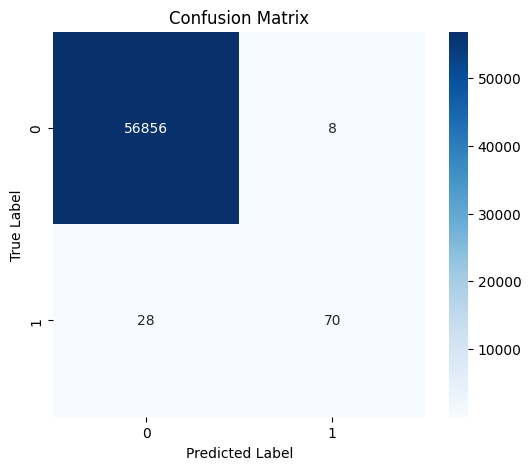

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




> #### Struktur Confusion Matrix:
|                | Prediksi: 0 | Prediksi: 1 |
|----------------|-------------|-------------|
| **Kelas Asli 0** | 56.856      | 8           |
| **Kelas Asli 1** | 28          | 70          |
>
> #### Interpretasi:
- **True Negative (TN): 56.856** → Transaksi normal yang diprediksi benar.
- **False Positive (FP): 8** → Transaksi normal yang salah diprediksi sebagai fraud.
- **False Negative (FN): 28** → Transaksi fraud yang tidak terdeteksi (salah dianggap normal).
- **True Positive (TP): 70** → Transaksi fraud yang berhasil dideteksi.
>
> #### Kesimpulan:
- Model sangat akurat untuk **kelas 0 (normal)**.
- Masih ada **28 kasus fraud** yang tidak terdeteksi → ini perlu perhatian lebih jika recall fraud menjadi prioritas utama.


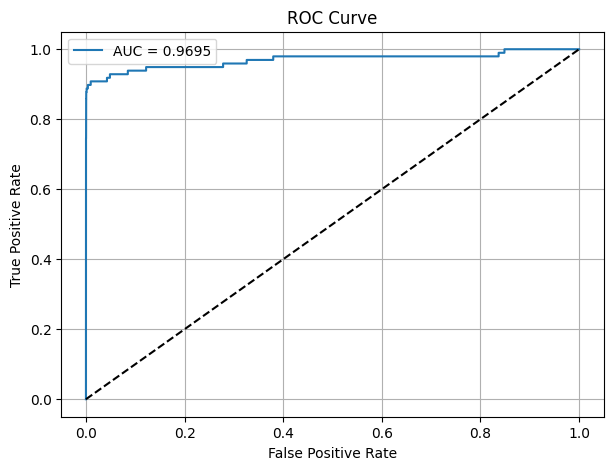

In [9]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

> ROC Curve menunjukkan performa model dalam membedakan dua kelas (fraud dan normal) di berbagai threshold.
>
> - **Sumbu X (False Positive Rate):** Proporsi data normal yang salah dikira fraud.
- **Sumbu Y (True Positive Rate):** Proporsi fraud yang benar terdeteksi (recall).
>
> #### AUC (Area Under Curve) = 0.9695
- AUC mendekati 1 → model sangat baik membedakan antara fraud dan normal.
- Kurva yang melengkung tajam ke kiri atas menunjukkan performa klasifikasi yang kuat.
>
> #### Kesimpulan:
- Model mampu **mendeteksi fraud dengan baik secara umum**, meskipun ada beberapa kasus yang terlewat.
- ROC Curve memperkuat hasil evaluasi metrik sebelumnya (precision, recall, f1-score).
